In [21]:
import os, sys, re, datetime, shutil, copy, json
import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib
from astropy.table import Table
from collections import OrderedDict
from matplotlib import cm

def list2str(inlist, format_str = '{}'):
    return '[' + ', '.join([format_str.format(t) for t in inlist]) + ']'


In [82]:
# User-defined global parameters

X_CO_H2 = 1e-4
X_CI_CO = 0.2

list_of_T_kin_for_N_repISM = [15., 20., 25., 50., 50., 100., 100.] # T_kin in K for repISM
list_of_d_V_for_N_repISM = [3., 10., 25., 50., 40., 70., 90.] # d_V in km/s for repISM
#list_of_n_H2_for_N_repISM = [3.16e2, 3.16e2, 3.16e2, 1e3, 1e3, 1e3, 1e3] # n_H2 in cm^-3 for repISM
list_of_R_CI10CO21_for_N_repISM = [0.1, 0.1, 0.1, 0.2, 0.06, 0.1, 0.5]
list_of_I_CO10_range_for_N_repISM = [
    (30.,50.), (100.,200.), (350.,500.), (800.,1000.), 
    (700.,1000.), (1000.,1400.), (2000.,2200.) ] # K km s-1 for representative ISM conditions
list_of_I_CO10_for_N_repISM = np.array([
        np.mean(flux_pair) for flux_pair in list_of_I_CO10_range_for_N_repISM
    ])

global_list_of_T_kin = np.arange(6., 202., 1.) * u.K # for xgrid

# 20220326
list_of_Sigma_mol_for_N_repISM = np.array([
        140.0, # Inner Galactic GMC, from Roman-Duval et al. (2010), MW BU-FCRAO GRS of 13CO
        300.0, # NGC3627 disk GMC, value by my guessing.
               # Note that Watanabe et al. (2019), NGC3627 Spiral Arm 20K NCO 2.1e17, 
               # Bar End 20K NCO 3.7e17, Nucleus 20K NCO 5.8e17, but [CO/H2] ~ 1e-5
        400.0, # NGC3627 bar end, value by my guessing.
        800.0, # NGC1808 SB disk, value by my guessing.
        10**2.94, # NGC4321 center, from Sun et al. (2018) Fig. 1, assumed metalZ-dependent alphaCO
        10**2.971, # NGC3627 center, from Sun et al. (2018) Fig. 1, assumed metalZ-dependent alphaCO
        1500.0, # NGC7469 center, value by my guessing.
    ]) # with helium
list_of_Sigma_H2_for_N_repISM = list_of_Sigma_mol_for_N_repISM / 1.36 # no helium
list_of_alphaCO10_for_N_repISM = list_of_Sigma_H2_for_N_repISM / list_of_I_CO10_for_N_repISM # no helium
list_of_N_H2_for_N_repISM = list_of_Sigma_H2_for_N_repISM * 0.624e20

# 20220326 (3) -- all normalize to NCO/dV=2.67e17
# list_of_N_CO_for_N_repISM = np.full(len(list_of_T_kin_for_N_repISM), fill_value=2.67e17) * \
#                             np.array(list_of_d_V_for_N_repISM)
# list_of_N_H2_for_N_repISM = list_of_N_CO_for_N_repISM / X_CO_H2
# list_of_Sigma_H2_for_N_repISM = list_of_N_H2_for_N_repISM / 0.624e20
# list_of_alphaCO10_for_N_repISM = list_of_Sigma_H2_for_N_repISM / list_of_I_CO10_for_N_repISM # no helium

list_of_N_CO_for_N_repISM = list_of_N_H2_for_N_repISM * X_CO_H2
list_of_N_CI_for_N_repISM = list_of_N_CO_for_N_repISM * X_CI_CO # 0.2 times of N_CO
print('list_of_alphaCO10_for_N_repISM', list2str(list_of_alphaCO10_for_N_repISM, '{:.3f}'))
print('list_of_Sigma_H2_for_N_repISM', list2str(list_of_Sigma_H2_for_N_repISM, '{:.3f}'))
print('list_of_Sigma_mol_for_N_repISM', list2str(list_of_Sigma_mol_for_N_repISM, '{:.3f}'))
print('list_of_N_H2_for_N_repISM', list2str(list_of_N_H2_for_N_repISM, '{:.3e}'))
print('list_of_N_CO_for_N_repISM', list2str(list_of_N_CO_for_N_repISM, '{:.3e}'))
print('list_of_N_CI_for_N_repISM', list2str(list_of_N_CI_for_N_repISM, '{:.3e}'))
print('list_of_N_CO_d_V_for_N_repISM', list2str(list_of_N_CO_for_N_repISM / np.array(list_of_d_V_for_N_repISM), 
                                                '{:.3e}'))


norm = matplotlib.colors.Normalize(vmin=18.05, vmax=19.35, 
                                   clip=True) # vmin=17.0+0.3, vmax=20.0-0.4, see 'calc_LTE_R_CI10CO21.ipynb'
cmap = cm.gist_rainbow_r
colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)
list_of_linecolor_for_N_repISM = ['#1e90ff', 'blue', '#1be5e4', 
                                  'green', 
                                  'orange', 'red', '#ff1e90' ] 
                                  # [colormapper.to_rgba(np.log10(t)) for t in global_list_of_N_CO]
list_of_linestyle_for_N_repISM = ['solid', 'dashdot', 'dashed', 
                                  'dotted', 
                                  {'loosely dashed': (0, (5, 10))}, 
                                  {'dotted': (0, (1, 3))}, 
                                  {'dotted': (0, (1, 1))} ]
list_of_linethick_for_N_repISM = [2.0, 2.0, 2.0, 
                                  1.5, 1.5, 1.5, 1.5]
list_of_linelabel_for_N_repISM = ['[1]', '[2]', '[3]', 
                                  '[4]', '[5]', '[6]', '[7]'] # or all set to None to show parameter values

z = 0.0 # redshift for T_CMB
#z = 2.0 # redshift for T_CMB


list_of_alphaCO10_for_N_repISM [2.574, 1.471, 0.692, 0.654, 0.753, 0.573, 0.525]
list_of_Sigma_H2_for_N_repISM [102.941, 220.588, 294.118, 588.235, 640.414, 687.798, 1102.941]
list_of_Sigma_mol_for_N_repISM [140.000, 300.000, 400.000, 800.000, 870.964, 935.406, 1500.000]
list_of_N_H2_for_N_repISM [6.424e+21, 1.376e+22, 1.835e+22, 3.671e+22, 3.996e+22, 4.292e+22, 6.882e+22]
list_of_N_CO_for_N_repISM [6.424e+17, 1.376e+18, 1.835e+18, 3.671e+18, 3.996e+18, 4.292e+18, 6.882e+18]
list_of_N_CI_for_N_repISM [1.285e+17, 2.753e+17, 3.671e+17, 7.341e+17, 7.992e+17, 8.584e+17, 1.376e+18]
list_of_N_CO_d_V_for_N_repISM [2.141e+17, 1.376e+17, 7.341e+16, 7.341e+16, 9.990e+16, 6.131e+16, 7.647e+16]


In [83]:
CO = {}
CO['Einstein_A'] = np.array([
    7.203e-08, 6.910e-07, 2.497e-06, 6.126e-06, 1.221e-05, 2.137e-05, 3.422e-05, 5.134e-05, 7.330e-05, 1.006e-04, 
    1.339e-04, 1.735e-04, 2.200e-04, 2.739e-04, 3.354e-04, 4.050e-04, 4.829e-04, 5.695e-04, 6.650e-04, 7.695e-04, 
    8.833e-04, 1.006e-03, 1.139e-03, 1.281e-03, 1.432e-03, 1.592e-03, 1.761e-03, 1.940e-03, 2.126e-03, 2.321e-03, 
    2.524e-03, 2.735e-03, 2.952e-03, 3.175e-03, 3.404e-03, 3.638e-03, 3.878e-03, 4.120e-03, 4.365e-03, 4.613e-03, 
])
CO['E_u'] = np.array([
    5.53,      16.60,   33.19,   55.32,   82.97,  116.16,  154.87,  199.11,  248.88, 304.16, 
    364.97,   431.29,  503.13,  580.49,  663.35,  751.72,  845.59,  944.97, 1049.84, 1160.20, 
    1276.05, 1397.38, 1524.19, 1656.47, 1794.23, 1937.44, 2086.12, 2240.24, 2399.82, 2564.83, 
    2735.28, 2911.15, 3092.45, 3279.15, 3471.27, 3668.78, 3871.69, 4079.98, 4293.64, 4512.67, 
])
CO['E_l'] = np.concatenate([
    [0.0], CO['E_u'][:-1]
])
CO['J_u'] = np.arange(
    1, len(CO['E_u'])+1
)
CO['J_l'] = np.arange(
    0, len(CO['E_u'])
)
CO['nu'] = np.array([
     115.2712018,  230.5380000,  345.7959899,  461.0407682,  576.2679305, 
     691.4730763,  806.6518060,  921.7997000, 1036.9123930, 1151.9854520, 
    1267.0144860, 1381.9951050, 1496.9229090, 1611.7935180, 1726.6025057, 
    1841.3455060, 1956.0181390, 2070.6159930, 2185.1346800, 2299.5698420, 
    2413.9171130, 2528.1720600, 2642.3303459, 2756.3875840, 2870.3394070, 
    2984.1814550, 3097.9093610, 3211.5187506, 3325.0052827, 3438.3646110, 
    3551.5923610, 3664.6841800, 3777.6357280, 3890.4427170, 4003.1007876, 
    4115.6055850, 4227.9527744, 4340.1381120, 4452.1571221, 4564.0056399, 
])

In [84]:
CI = {}
CI['Einstein_A'] = np.array([
    7.880E-08, 2.650E-07, 
    #1.810E-14, 
])
CI['E_u'] = np.array([
    23.620, 62.462, 
    # 62.462, 
])
CI['E_l'] = np.concatenate([
    [0.0], CI['E_u'][:-1]
])
CI['J_u'] = np.arange(
    1, len(CI['E_u'])+1
)
CI['J_l'] = np.arange(
    0, len(CI['E_u'])
)
CI['nu'] = np.array([
    492.160651, 809.34197, 
    # 1301.50262, 
])

In [85]:
def calc_Q(E_u, T_kin, N=None):
    E_j = np.concatenate([[0.0], E_u])
    if N is None:
        N = len(E_j)
    j = np.arange(N)
    E_j = E_j[0:N]
    if np.isscalar(T_kin):
        Q = np.sum(1.0 * (j+(j+1)) * np.exp(-1.0 * E_j / T_kin))
    else:
        Q = np.array([
            np.sum(1.0 * (j+(j+1)) * np.exp(-1.0 * E_j / tkin.value)) for tkin in T_kin
        ])
    return Q

In [86]:
def calc_Bnu(
        nu, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    Bnu = 2*h*(nu*1e9)**3/c**2 * (1.0 / (np.exp(hnu_kt) - 1.0))
    return Bnu

def calc_tau(
        nu, 
        g_u, 
        E_u,
        Q, 
        A_ul, 
        N_dV, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    if isinstance(T_ex, u.Quantity):
        T_ex = T_ex.cgs.value
    if isinstance(nu, u.Quantity):
        nu = nu.cgs.value
    if isinstance(E_u, u.Quantity):
        E_u = E_u.to(u.K).value
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    E_u_kt = E_u/T_ex
    N_dV_cm_2_km_s_1 = N_dV # input should have a unit of cm^{-2} (km s^{-1})^{-1}
    N_dV_cm_2_cm_s_1 = N_dV_cm_2_km_s_1 / 1e5 # km^{-1} to cm^{-1}
    return c**3/(8.0*pi*(nu*1e9)**3) * (g_u/Q) * A_ul \
           * np.exp(E_u_kt) \
           * N_dV_cm_2_cm_s_1 / 1.0645 \
           * (1.0 - np.exp( -hnu_kt ))

def calc_C_coeff(
        species = 'CO', 
        transition = 0, 
        z = 0.0,
        do_print = False, 
    ):
    # 
    if species == 'CO':
        global CO
        species_moldata = CO
    elif species == 'CI':
        global CI
        species_moldata = CI
    else:
        raise Exception('Error! The input species must be either "CO" or "CI"!')
    # 
    nu = species_moldata['nu'][transition] * u.GHz
    A_ul = species_moldata['Einstein_A'][transition] * u.s**(-1)
    j_u = species_moldata['J_u'][transition]
    j_l = species_moldata['J_l'][transition]
    g_u = j_u + (j_u + 1)
    # 
    # 8 pi kB nu^2 / ( h c^3 )
    coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
    #print('coe1', coe1)
    # 
    # 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
    coe2 = coe1 / g_u / A_ul
    #print('coe2', coe2)
    # 
    # 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
    coe3 = (coe2 * (const.m_p + const.m_e).cgs*2).to(u.M_sun * u.pc**(-2) * u.K**(-1) * u.km**(-1) * u.s)
    #print('coe3', coe3)
    # 
    # [X/H2]^{-1} * 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul * 100 [M_sun pc-2 (K km s-1)-1]
    coe4 = coe3 / 1e-4
    #print('coe4', coe4, species, transition)
    # 
    C_coeff = coe4
    if do_print:
        print(f'{species} {j_u} -> {j_l} C = {C_coeff:.8g}')
    # 
    return C_coeff

def calc_QE_term(
        list_of_T_kin, 
        species = 'CO', 
        transition = 0, 
        z = 0.0,
    ):
    # 
    if species == 'CO':
        global CO
        species_moldata = CO
    elif species == 'CI':
        global CI
        species_moldata = CI
    else:
        raise Exception('Error! The input species must be either "CO" or "CI"!')
    # 
    nu = species_moldata['nu'][transition] * u.GHz
    A_ul = species_moldata['Einstein_A'][transition] * u.s**(-1)
    E_u = species_moldata['E_u'][transition] * u.K
    j_u = species_moldata['J_u'][transition]
    g_u = j_u + (j_u + 1)
    Q = calc_Q(species_moldata['E_u'], list_of_T_kin)
    T_CMB = 2.73 * (1.0 + z) * u.K
    hnuk = const.h.cgs * nu.cgs / const.k_B.cgs
    eEukt = np.exp(E_u / list_of_T_kin)
    ehnukt = np.exp(hnuk / list_of_T_kin)
    ehnuktcmb = np.exp(hnuk / T_CMB)
    Bnuratio = 1.0 / ( 1.0 - ( (ehnukt-1.0) / (ehnuktcmb-1.0) ) )
    QE_term = Q * eEukt * Bnuratio
    return QE_term

def calc_alphaX(
        T_kin, 
        tau, 
        species = 'CO', 
        species_abundance = 1e-4, 
        transition = 0, 
        z = 0.0,
    ):
    C_coeff = calc_C_coeff(species=species, transition=transition, z=z)
    QE_term = calc_QE_term(T_kin, species=species, transition=transition, z=z)
    tau_term = tau / (1.0 - np.exp(-tau))
    alpha_X = C_coeff.value * 1e-4 / species_abundance * QE_term * tau_term
    return alpha_X


if __name__ == '__main__':
    calc_C_coeff(species='CO', transition=0, z=0.0, do_print=True)
    calc_C_coeff(species='CO', transition=1, z=0.0, do_print=True)
    calc_C_coeff(species='CI', transition=0, z=0.0, do_print=True)
    calc_C_coeff(species='CI', transition=1, z=0.0, do_print=True)


CO 1 -> 0 C = 0.019154525 s solMass / (K km pc2)
CO 2 -> 1 C = 0.0047918301 s solMass / (K km pc2)
CI 1 -> 0 C = 0.31917637 s solMass / (K km pc2)
CI 2 -> 1 C = 0.15399715 s solMass / (K km pc2)


### Prepare function to plot the alphaX, Q-E and tau functions

In [167]:
# define function to plot one set of alphaX, QE and tau terms, as functions of T

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 11.5
matplotlib.rcParams['ytick.labelsize'] = 11.5
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['axes.formatter.useoffset'] = False
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.cal'] = 'stix:italic'
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
import matplotlib.patheffects as path_effects

def set_xticks_log(ax):
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    #ax.xaxis.set_major_locator(ticker.LogLocator(base=10, subs=(1,2,3,5)))
    ax.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax.set_xlim(ax.get_xlim())
    ax.set_xticks([5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 
                   60, 70, 80, 90, 100, 200])
    ax.set_xticklabels(['5', '', '', '', '', '10', '20', '30', '40', '50', 
                        '', '', '', '', '100', '200'])

def make_a_plot_for_one_line(
        list_of_T_kin=None, 
        species='CO', 
        transition=0,
        z=0.0, 
        top_left_text=None, 
        first_panel_text=None, 
        out_fig_name=None, 
        return_popt=False,
    ):
    
    global list_of_T_kin_for_N_repISM
    global list_of_N_CO_for_N_repISM
    global list_of_N_CI_for_N_repISM
    global list_of_d_V_for_N_repISM
    global list_of_Sigma_H2_for_N_repISM
    global list_of_linestyle_for_N_repISM
    global list_of_linecolor_for_N_repISM
    global list_of_linelabel_for_N_repISM
    global list_of_linethick_for_N_repISM
    global X_CO_H2
    global X_CI_CO
    
    if species == 'CO':
        global CO
        species_moldata = CO
        species_abundance = X_CO_H2
        list_of_N_species_for_N_repISM = list_of_N_CO_for_N_repISM
    elif species == 'CI':
        global CI
        species_moldata = CI
        species_abundance = X_CO_H2 * X_CI_CO
        list_of_N_species_for_N_repISM = list_of_N_CI_for_N_repISM
    else:
        raise Exception('Error! The input species must be either "CO" or "CI"!')
    
    # calculate coefficients
    nu = species_moldata['nu'][transition]
    j_u = species_moldata['J_u'][transition]
    j_l = species_moldata['J_l'][transition]
    g_u = j_u + (j_u + 1)
    E_u = species_moldata['E_u'][transition]
    A_ul = species_moldata['Einstein_A'][transition]
    
    # set figure
    fig = plt.figure(figsize=(16, 4.5))
    fig.subplots_adjust(bottom=0.11, top=0.88, left=0.05, right=0.99)
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    linename = f'{species}{j_u:g}{j_l:g}'
    ax1.set_xlabel(r'$T \ / \ [\mathrm{K}]$', fontsize=14, labelpad=3)
    ax1.set_ylabel(f'$\\alpha_{{\\rm {linename}}}^{{\\rm H_2, LTE}}$', fontsize=14, labelpad=12)
    ax2.set_xlabel(r'$T \ / \ [\mathrm{K}]$', fontsize=14, labelpad=3)
    ax2.set_ylabel(f'$[Q{{\\cdot}}E]_{{\\rm {linename}}}$', fontsize=14, labelpad=12)
    ax3.set_xlabel(r'$T \ / \ [\mathrm{K}]$', fontsize=14, labelpad=3)
    ax3.set_ylabel(f'$[\\tau]_{{\\rm {linename}}}$', fontsize=14, labelpad=12)
    
    # set T_CMB
    T_CMB = 2.73 * (1.0 + z) * u.K
    
    # check input xgrid
    if list_of_T_kin is None:
        list_of_T_kin = copy.copy(global_list_of_T_kin)
    if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
        list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
    
    # make sure list_of_T_kin has units
    if not isinstance(list_of_T_kin[0], u.Quantity):
        list_of_T_kin = list_of_T_kin * u.K
        
    # calculate parition function Q
    list_of_Q = calc_Q(species_moldata['E_u'], list_of_T_kin)
    
    # loop repr. ISM conditions
    print('list_of_N_species_for_N_repISM', list_of_N_species_for_N_repISM) # column density
    print('list_of_Sigma_H2_for_N_repISM', list_of_Sigma_H2_for_N_repISM)
    print('list_of_d_V_for_N_repISM', list_of_d_V_for_N_repISM)
    
    # calculate tau for each representative ISM (repISM)
    list_of_tau_for_N_repISM = []
    for idx_N_repISM, N_species in enumerate(list_of_N_species_for_N_repISM):
        N_species = float(N_species)
        N_species_str = re.sub(r'e\+(0+|)', r'e', '%.1e'%(N_species))
        d_V = list_of_d_V_for_N_repISM[idx_N_repISM]
        d_V_str = '%.1f'%(d_V)
        N_d_V = N_species / d_V
        N_d_V_str = re.sub(r'e\+(0+|)', r'e', '%.1e'%(N_d_V))
        # 
        list_of_tau = calc_tau(
            nu = nu, 
            g_u = g_u, 
            E_u = E_u,
            Q = list_of_Q, 
            A_ul = A_ul,
            N_dV = N_d_V, 
            T_ex = list_of_T_kin, 
        )
        # 
        list_of_QE_term = calc_QE_term(
            list_of_T_kin, 
            species = species, 
            transition = transition, 
            z = z,
        )
        # 
        list_of_tau_term = list_of_tau * (1.0 - np.exp(-list_of_tau))
        # 
        list_of_alphaX = calc_alphaX(
            list_of_T_kin, 
            list_of_tau, 
            species = species, 
            species_abundance = species_abundance, 
            transition = transition, 
            z = z,
        )
        # 
        linestyle = list_of_linestyle_for_N_repISM[idx_N_repISM]
        linethick = list_of_linethick_for_N_repISM[idx_N_repISM]
        linecolor = list_of_linecolor_for_N_repISM[idx_N_repISM]
        linelabel = list_of_linelabel_for_N_repISM[idx_N_repISM]
        Sigma_H2 = list_of_Sigma_H2_for_N_repISM[idx_N_repISM]
        Sigma_H2_str = '%.0f'%(Sigma_H2)
        Sigma_mol_str = '%.0f'%(Sigma_H2*1.36) # Helium
        if linelabel is None or linelabel == '':
            linelabel = r'$N_{\mathrm{%s}}$=%s'%(species, N_species_str) + \
                        r', $\Sigma_{\mathrm{mol}}$=%s'%(Sigma_mol_str) + \
                        r', $\Delta v$=%g'%(d_V) + \
                        '\n' + \
                        r'$N_{\mathrm{%s}}/{\Delta v} = %s$'%(species, N_d_V_str)
        if isinstance(linestyle, dict):
            linestyle = [linestyle[t] for t in linestyle][0]
        #
        ax1.plot(list_of_T_kin, list_of_alphaX, 
                 ls=linestyle, 
                 lw=linethick, 
                 color=linecolor, 
                 label=linelabel, 
                )
        ax2.plot(list_of_T_kin, list_of_QE_term, 
                 ls=linestyle, 
                 lw=linethick, 
                 color=linecolor, 
                 label=linelabel, 
                )
        ax3.plot(list_of_T_kin, list_of_tau_term, 
                 ls=linestyle, 
                 lw=linethick, 
                 color=linecolor, 
                 label=linelabel, 
                )
    
    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    if species == 'CO' and transition == 0:
        ax1.yaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8), ))
    elif species == 'CO' and transition == 1:
        ax1.yaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5, ), ))
        ax1.set_ylim([ax1.get_ylim()[0], 200.])
    elif species == 'CI' and transition == 0:
        ax1.yaxis.set_major_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.5), ))
        ax1.yaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5), ))
        ax1.set_ylim([ax1.get_ylim()[0], 500.])
    elif species == 'CI' and transition == 1:
        #ax1.yaxis.set_major_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.5), ))
        ax1.yaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.5), ))
        ax1.set_ylim([5.0, 5000.])
    ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%g'))
    set_xticks_log(ax1)
    
    ax2.set_yscale('log')
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax2.yaxis.set_major_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.5)))
    set_xticks_log(ax2)
    
    ax3.set_yscale('log')
    ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    set_xticks_log(ax3)

    # fix ax axis ranges
    ax1.set_xlim(ax1.get_xlim())
    ax1.set_ylim(ax1.get_ylim())
    ax2.set_xlim(ax2.get_xlim())
    ax2.set_ylim(ax2.get_ylim())
    ax3.set_xlim(ax3.get_xlim())
    ax3.set_ylim(ax3.get_ylim())
    
    # show top text in panel 1
    if first_panel_text is not None:
        if species == 'CO':
            panel1_label = first_panel_text # + '\n' + r'$\approx \ ' + latex_str_func_alpha_CO(*popt) + '$'
            t_exp = int(np.floor(np.log10(species_abundance)))
            t_val = species_abundance / 10**t_exp
            str_abun = r'[\mathrm{CO/H_2}]'
        elif species == 'CI':
            panel1_label = first_panel_text # + '\n' + r'$\approx \ ' + latex_str_func_alpha_CI(*popt) + '$'
            t_exp = int(np.floor(np.log10(species_abundance)))
            t_val = species_abundance / 10**t_exp
            str_abun = r'[\mathrm{C}_{\tt{I}}/\mathrm{H_2}]'
        str_val = '{:g}'.format(t_val)
        str_exp = '{:d}'.format(t_exp)
        #panel1_label += ('\n' + r'   $ \times \; (' + str_val + \
        #                 r' \times 10^{' + str_exp + r'} \;/\; ' + str_abun + r')$')
        tt1 = ax1.text(0.05, 1.03, 
                       panel1_label, 
                       ha='left', va='bottom', transform=ax1.transAxes, fontsize=14)
        tt1.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='#666666'))
    
    # show legend at the right side of panel 3
    #ax3.legend(fontsize=12, loc='center left', bbox_to_anchor=(1.0, 0.1, 0.5, 0.8))

    # show legend at the top side of panel 2
    ax2.legend(fontsize=12, loc='lower left', bbox_to_anchor=(0.0, 1.01, 1.0, 0.5), 
               ncol=len(list_of_linestyle_for_N_repISM),
               #handlelength
              )
    
    # show canonical alphaCO in panel 1
    if species == 'CO' and transition == 0:
        highlight_y = 4.35/1.36 # Bolatto+2013 ARA&A, 1./1.36 removes the Helium
        highlight_color = 'blue'
        highlight_fill = ax1.fill_between(ax1.get_xlim(), 
                                          [highlight_y/1.2]*2, 
                                          [highlight_y*1.2]*2, 
                                          lw=0.0, alpha=0.3, color=highlight_color)
        highlight_tt = ax1.text(
            ax1.get_xlim()[1]-0.04*(ax1.get_xlim()[1]-ax1.get_xlim()[0]), 
            highlight_y, 
            '"Galactic"', ha='right', va='center', color=highlight_color, fontsize=13)
        highlight_tt.set_path_effects(
            [path_effects.Stroke(linewidth=0.3, foreground='k'), path_effects.Normal()])
        # 
        highlight_y = 0.6 # Papadopoulos+2012 ApJ # or ULIRG 0.8/1.36 # 
        highlight_color = 'red'
        highlight_fill = ax1.fill_between(ax1.get_xlim(), 
                                          [highlight_y/1.1]*2, 
                                          [highlight_y*1.1]*2, 
                                          lw=0.0, alpha=0.3, color=highlight_color)
        highlight_tt = ax1.text(
            ax1.get_xlim()[1]-0.04*(ax1.get_xlim()[1]-ax1.get_xlim()[0]), 
            highlight_y, 
            '"Starburst"', ha='right', va='center', color=highlight_color, fontsize=13)
        highlight_tt.set_path_effects(
            [path_effects.Stroke(linewidth=0.3, foreground='k'), path_effects.Normal()])
        # 
        ax1.annotate('', xy=(15.0, 3.2), xytext=(15.0, 0.8), xycoords='data', textcoords='data', va='top', 
                     arrowprops=dict(facecolor='blue', edgecolor='none', shrink=0.05, width=1.5, 
                                     headwidth=10., alpha=0.8),
                    )

    # show top left text and set out fig name
    if z > 0.0:
        top_left_text = top_left_text + r' $z = {:g}$'.format(z)
    tt1 = ax1.text(0.50, 0.96, top_left_text, ha='center', va='top', transform=ax1.transAxes, fontsize=14)
    tt1.set_path_effects([path_effects.Stroke(linewidth=0.6, foreground='black'), path_effects.Normal()])
    
    # tight layout
    #fig.tight_layout()
    
    # output figure to file
    if out_fig_name is not None:
        if z > 0.0:
            out_fig_name = copy.copy(out_fig_name)
            out_fig_name += '_z{:g}'.format(z)
        fig.savefig(out_fig_name+'.pdf', dpi=300)
        print('Output to "%s"'%(out_fig_name+'.pdf'))
    
    # return
    return fig


### Now we plot the alpha factor and tau term vs T_kin

list_of_N_species_for_N_repISM [6.42352941e+17 1.37647059e+18 1.83529412e+18 3.67058824e+18
 3.99618588e+18 4.29186133e+18 6.88235294e+18]
list_of_Sigma_H2_for_N_repISM [ 102.94117647  220.58823529  294.11764706  588.23529412  640.41440438
  687.79828981 1102.94117647]
list_of_d_V_for_N_repISM [3.0, 10.0, 25.0, 50.0, 40.0, 70.0, 90.0]
Output to "Plot_new_new_LTE_alpha_CO10.pdf"


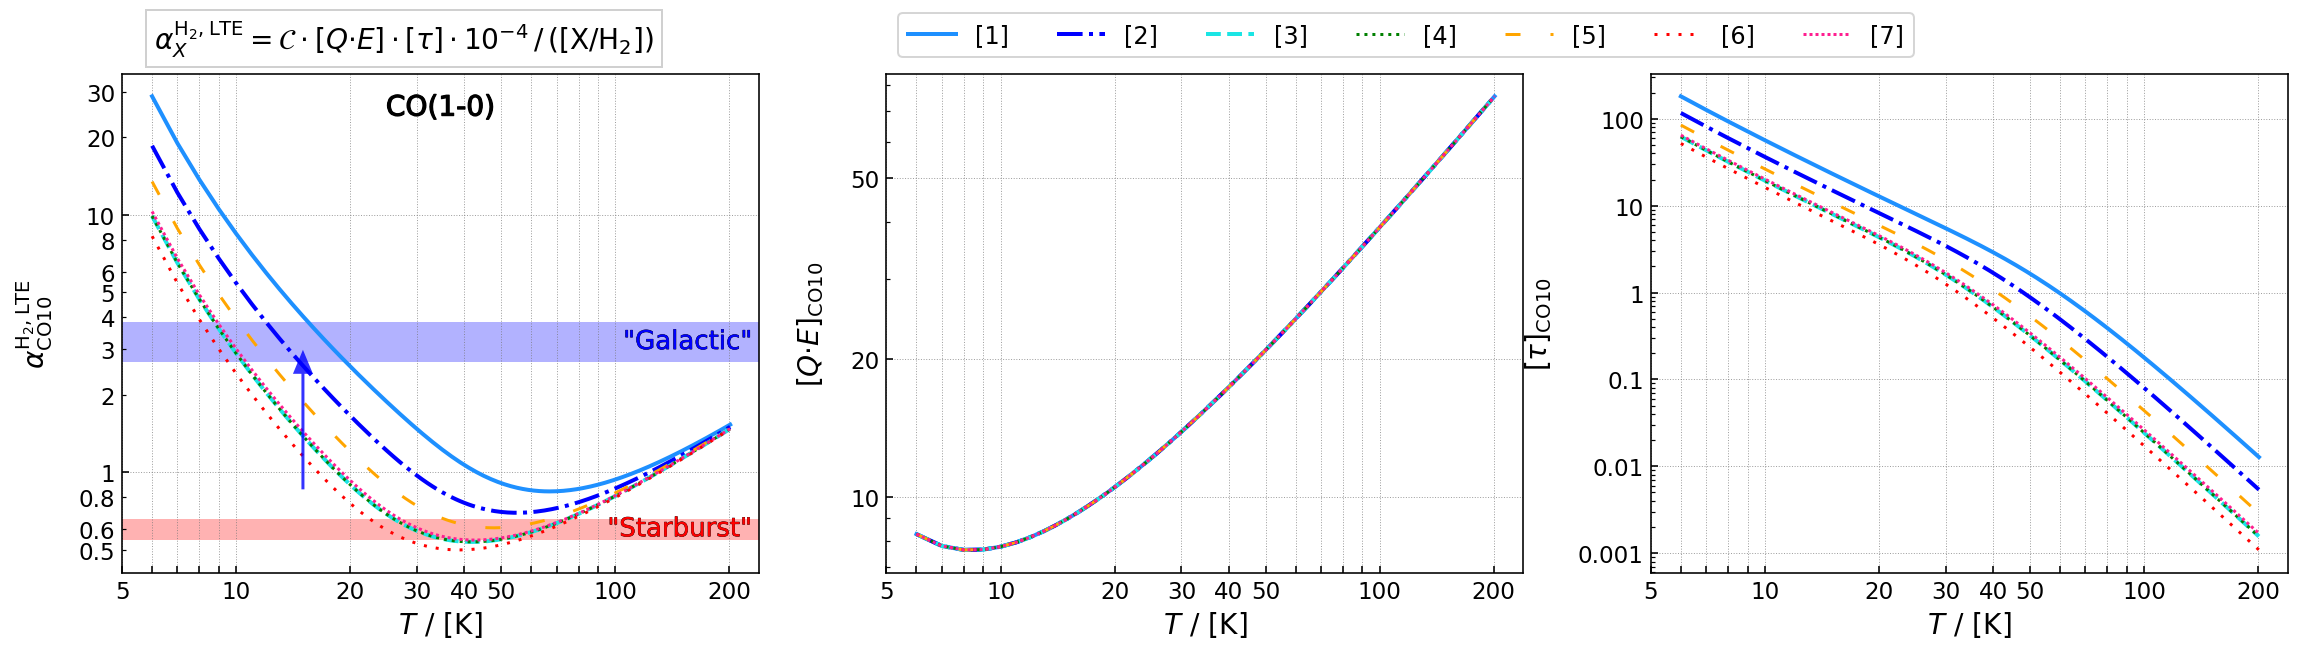

In [168]:
# tau CO10

if __name__ == '__main__' and '__file__' not in globals():

    top_left_text = 'CO(1-0)'
    out_fig_name = 'Plot_new_new_LTE_alpha_CO10'
    first_panel_text = r'$\alpha_{X}^{\rm H_2, LTE} = $' + \
                       r'$\mathcal{C} \cdot [Q{\cdot}E] \cdot [\tau] \cdot 10^{-4} \, / \, (\mathrm{[X/H_2]})$'
                       # alphaCO10 function
    fig = make_a_plot_for_one_line(
            species='CO', 
            transition=0, 
            z=z, 
            first_panel_text=first_panel_text, 
            top_left_text=top_left_text, 
            out_fig_name=out_fig_name, 
        )


list_of_N_species_for_N_repISM [6.42352941e+17 1.37647059e+18 1.83529412e+18 3.67058824e+18
 3.99618588e+18 4.29186133e+18 6.88235294e+18]
list_of_Sigma_H2_for_N_repISM [ 102.94117647  220.58823529  294.11764706  588.23529412  640.41440438
  687.79828981 1102.94117647]
list_of_d_V_for_N_repISM [3.0, 10.0, 25.0, 50.0, 40.0, 70.0, 90.0]
Output to "Plot_new_new_LTE_alpha_CO21.pdf"


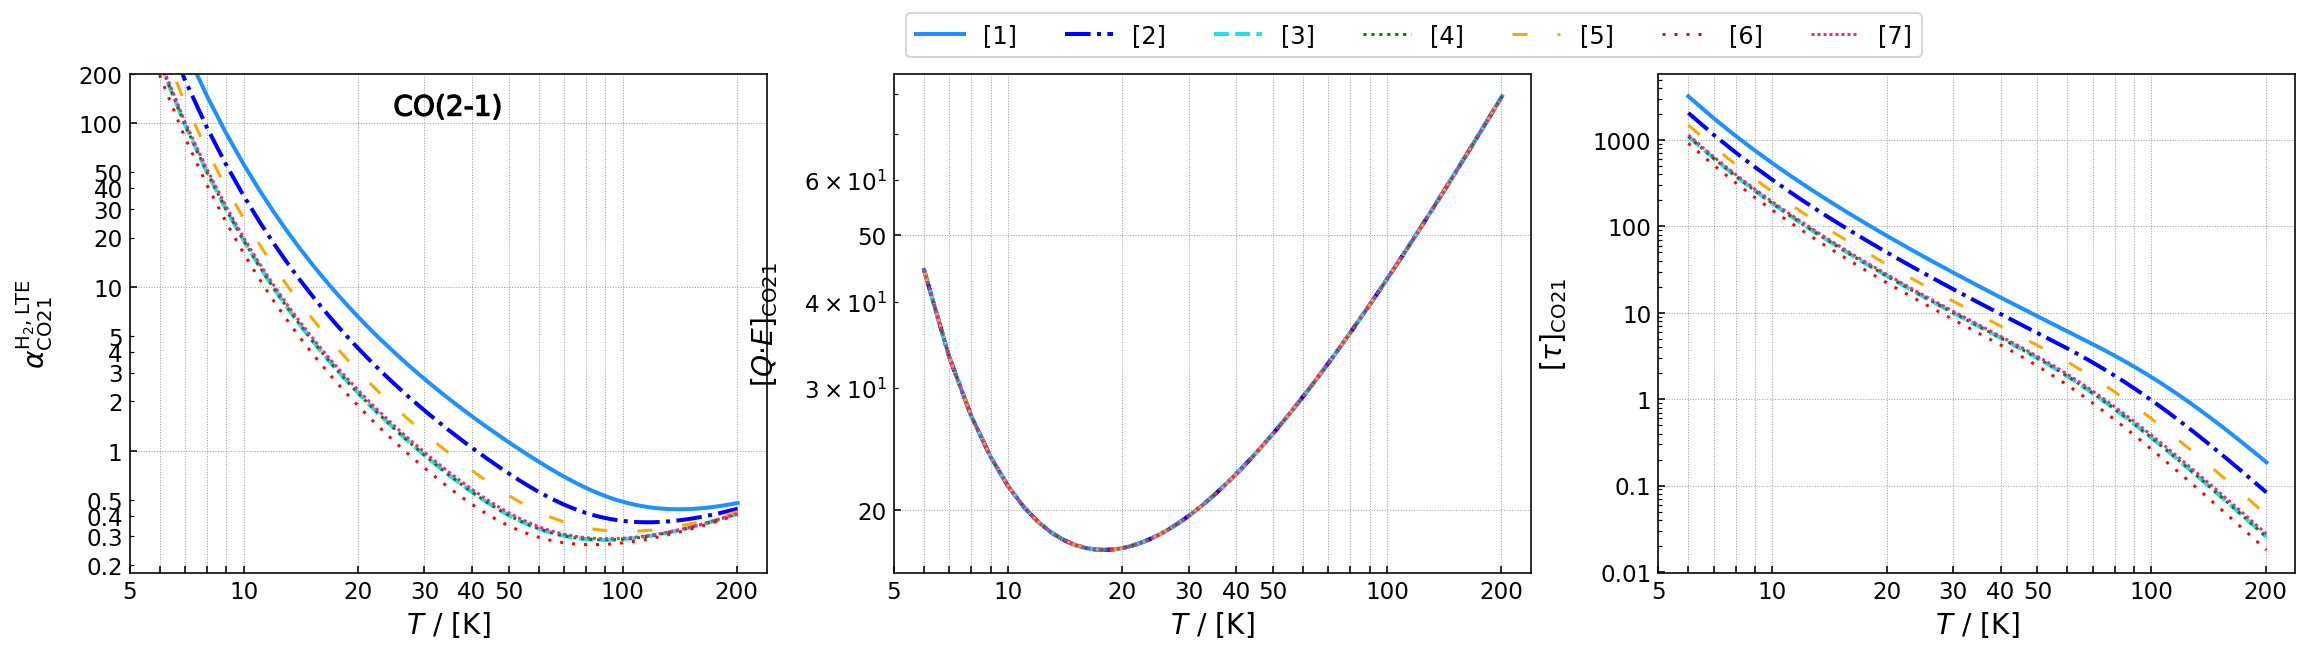

In [169]:
# tau CO21

if __name__ == '__main__' and '__file__' not in globals():

    top_left_text = 'CO(2-1)'
    out_fig_name = 'Plot_new_new_LTE_alpha_CO21'
    first_panel_text = None
    fig = make_a_plot_for_one_line(
            species='CO', 
            transition=1, 
            z=z, 
            first_panel_text=first_panel_text, 
            top_left_text=top_left_text, 
            out_fig_name=out_fig_name, 
        )


list_of_N_species_for_N_repISM [1.28470588e+17 2.75294118e+17 3.67058824e+17 7.34117647e+17
 7.99237177e+17 8.58372266e+17 1.37647059e+18]
list_of_Sigma_H2_for_N_repISM [ 102.94117647  220.58823529  294.11764706  588.23529412  640.41440438
  687.79828981 1102.94117647]
list_of_d_V_for_N_repISM [3.0, 10.0, 25.0, 50.0, 40.0, 70.0, 90.0]
Output to "Plot_new_new_LTE_alpha_CI10.pdf"


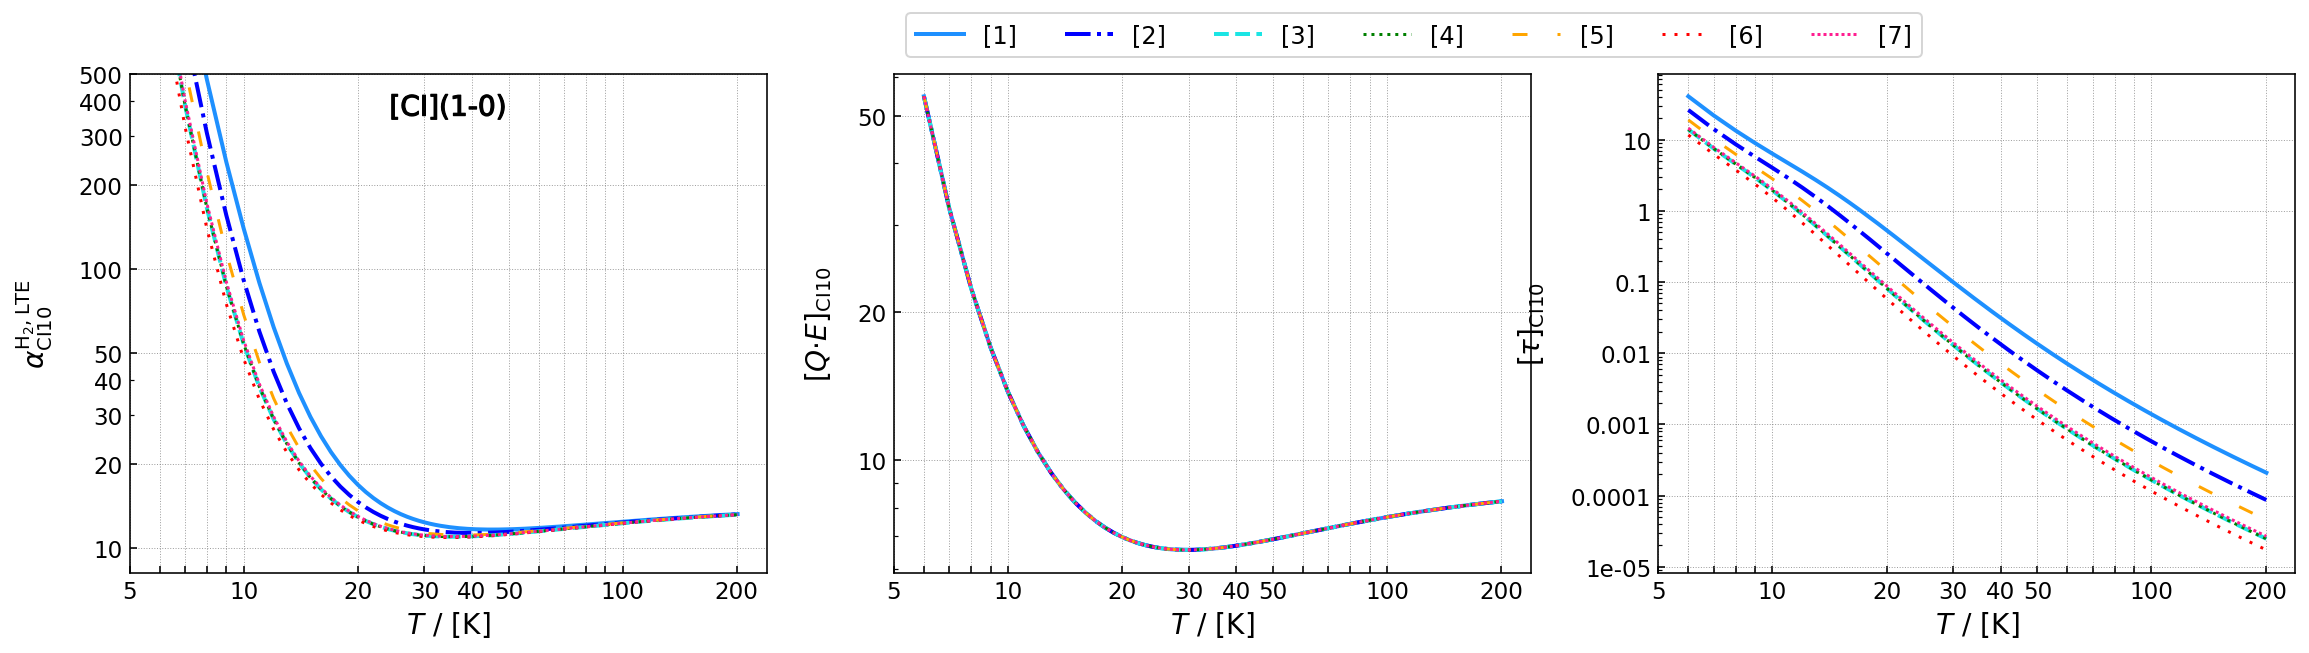

In [170]:
# tau CI10

if __name__ == '__main__' and '__file__' not in globals():

    top_left_text = '[CI](1-0)'
    out_fig_name = 'Plot_new_new_LTE_alpha_CI10'
    first_panel_text = None
    fig = make_a_plot_for_one_line(
            species='CI', 
            transition=0, 
            z=z, 
            first_panel_text=first_panel_text, 
            top_left_text=top_left_text, 
            out_fig_name=out_fig_name, 
        )



list_of_N_species_for_N_repISM [1.28470588e+17 2.75294118e+17 3.67058824e+17 7.34117647e+17
 7.99237177e+17 8.58372266e+17 1.37647059e+18]
list_of_Sigma_H2_for_N_repISM [ 102.94117647  220.58823529  294.11764706  588.23529412  640.41440438
  687.79828981 1102.94117647]
list_of_d_V_for_N_repISM [3.0, 10.0, 25.0, 50.0, 40.0, 70.0, 90.0]
Output to "Plot_new_new_LTE_alpha_CI21.pdf"


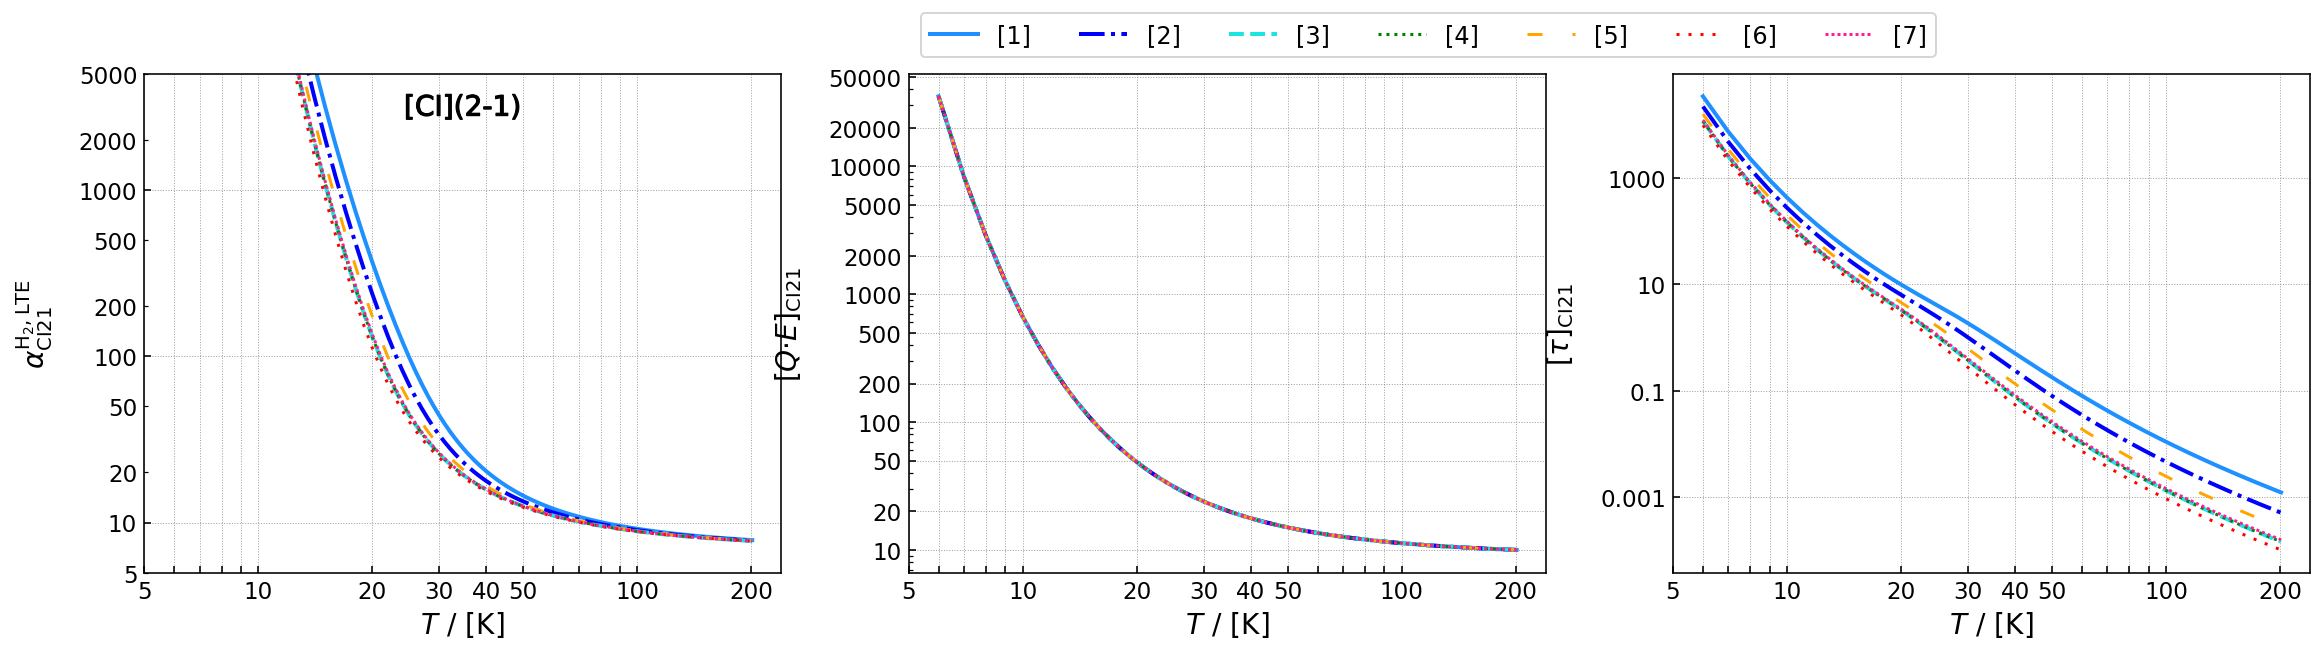

In [171]:
# tau CI21

if __name__ == '__main__' and '__file__' not in globals():

    top_left_text = '[CI](2-1)'
    out_fig_name = 'Plot_new_new_LTE_alpha_CI21'
    first_panel_text = None
    fig = make_a_plot_for_one_line(
            species='CI', 
            transition=1, 
            z=z, 
            first_panel_text=first_panel_text, 
            top_left_text=top_left_text, 
            out_fig_name=out_fig_name, 
        )

